# Assignment 3
In this assignment, you will be coding two new (nn.Module)s that implement a Linear layer and BatchNorm. Then you will use them to train a conv net over multiple datasets.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Datasets**
In this assignment you will only use training sets. Here, I only load CIFAR10, but you should load the following datasets, which you will use later:


*   CIFAR10
*   Fashion-MNIST
*  KMNIST




In [ ]:
cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=64,
                                          shuffle=True)

fashion_mnist_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

fashion_mnist_trainloader = torch.utils.data.DataLoader(fashion_mnist_trainset, batch_size=64,
                                          shuffle=True)

kmnist_trainset = torchvision.datasets.KMNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

kmnist_trainloader = torch.utils.data.DataLoader(kmnist_trainset, batch_size=64,
                                          shuffle=True)

Files already downloaded and verified


# Neural net
This is our vanilla CNN for this experiment. The sizes of the Linear layers were designed for CIFAR10, the first dataset you should experiment with. Later, you will have to change those numbers to fit the other datasets.

In [ ]:
class CNN(nn.Module):

    def __init__(self, batch_norm_layer=False, isCifar10=False):
        super(CNN, self).__init__()

        # BatchNorm layer
        self.batch_norm = batch_norm_layer
        self.isCifar10 = isCifar10

        if isCifar10:
          self.conv1= nn.Conv2d(3, 6, 5)
          self.fc1 = nn.Linear(16 * 5 * 5, 120)
        else:
          self.conv1 = nn.Conv2d(1, 6, 5)
          self.fc1 = nn.Linear(16 * 4 * 4, 120)
          
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # now a few fully connected layers
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        if self.batch_norm:
          self.bn1 = MyBatchNorm(120)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))

        if self.batch_norm:
          x = self.bn1(x)

        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
# training loop

def train(model, loader, epochs=100, opt='adam', learning_rate=0.003):

  if opt == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  elif opt == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  criterion = nn.CrossEntropyLoss()

  history = { 'epochs_loss' : [] }                 

  batch_size = loader.batch_size

  for epoch in tqdm(range(epochs)):

    running_loss = 0.0
    epoch_batches_losses = []

    for i, data in enumerate(loader, 0):
        # get the inputs
        inputs, labels = data
        
        inputs = inputs.cuda() # -- For GPU
        labels = labels.cuda() # -- For GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % batch_size == 0:    
            # print('[%d, %5d] loss: %.3f' %
            #       (epoch + 1, i + 1, running_loss / 200))
            # print(f'Batch {((i+1)/batch_size) + 1}: {running_loss / float(batch_size)}')
            batch_loss = running_loss / float(batch_size)
            epoch_batches_losses.append(batch_loss)
            running_loss = 0.0
    epoch_loss = sum(epoch_batches_losses) / len(epoch_batches_losses)
    print(f'epoch: {epoch + 1} loss: {epoch_loss}')
    history['epochs_loss'].append(epoch_loss)

  print('Finished Training')
  return history

# Task 1
Implement a nn.Module that immitates nn.Linear, with additional support for Dropout. In other words, this module should take three arguments: input dimension, output dimension and the keep_prop probability for dropout. Make sure to wrap your parameter tensors with nn.Parameter.

In [ ]:
# TODO: Implement the following Module. Size is the length of the input vectors.

class MyLinear(nn.Module):
  def __init__(self, input_dim, output_dim, keep_prob=0.):
    super(MyLinear, self).__init__()
    if keep_prob < 0 or keep_prob > 1:
            raise ValueError("dropout probability has to be between 0 and 1, "
                             "but got {}".format(keep_prob))
    else:
      self.dropout = 1 - keep_prob

    self.weight = nn.init.xavier_normal_(nn.Parameter(torch.empty(output_dim, input_dim)))
    self.bias = nn.init.xavier_normal_(nn.Parameter(torch.empty(1, output_dim)))
    
  def forward(self, x):
    dropout_layer = F.dropout(x, self.dropout).to(device=device)
    output = (dropout_layer @ self.weight.t().to(device=device)) + self.bias.to(device=device)
    return output

# Task 2
You should add your new MyLinear Module to our CNN. Simply replace fc1, fc2, and fc3 with your new module, this time with keep_prob=1. Then, train the network over CIFAR10 with and without your Module, and compare the loss curves (plot both of them onto the same figure, with two different colors).



In [ ]:
# plot both curves on a single canvas
def plot_loss(losses_1, title_1, losses_2, title_2):
  plt.title(f'Loss curves of {title_1} and {title_2}')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.plot(losses_1)
  plt.plot(losses_2,color='green')
  plt.legend((title_1, title_2), fontsize=12)

Training cifar10 without dropout layers


epoch: 1 loss: 1.7675162345791857
epoch: 2 loss: 1.5288838255219162
epoch: 3 loss: 1.4563571040829022
epoch: 4 loss: 1.3982388217312594
epoch: 5 loss: 1.3493910878120612
epoch: 6 loss: 1.3220830589998513
epoch: 7 loss: 1.2942162306668858
epoch: 8 loss: 1.2724482143918674
epoch: 9 loss: 1.2486159949718665
epoch: 10 loss: 1.2380243776521336
epoch: 11 loss: 1.21798048967806
epoch: 12 loss: 1.196717910701409
epoch: 13 loss: 1.1774025225701432
epoch: 14 loss: 1.1672792700119317
epoch: 15 loss: 1.1505078229432304
epoch: 16 loss: 1.1364132536109537
epoch: 17 loss: 1.1341741535967838
epoch: 18 loss: 1.1133140180415164
epoch: 19 loss: 1.1080773420011003
epoch: 20 loss: 1.0953894470973562
epoch: 21 loss: 1.088510129135102
epoch: 22 loss: 1.0806897818886985
epoch: 23 loss: 1.070894192205742
epoch: 24 loss: 1.0603729531479378
epoch: 25 loss: 1.0551516377987962
epoch: 26 loss: 1.0531557086699952
epoch: 27 loss: 1.0482987420012553
epoch: 28 loss: 1.036635047988966
epoch: 29 loss: 1.0333017491114636


epoch: 1 loss: 1.716349759294341
epoch: 2 loss: 1.4361084081077327
epoch: 3 loss: 1.3154258511494845
epoch: 4 loss: 1.2436478838014107
epoch: 5 loss: 1.1851076666886609
epoch: 6 loss: 1.1333814274209242
epoch: 7 loss: 1.103101279431333
epoch: 8 loss: 1.067673268650348
epoch: 9 loss: 1.0409931528847665
epoch: 10 loss: 1.0141575475378584
epoch: 11 loss: 0.9906559411901981
epoch: 12 loss: 0.970422332175076
epoch: 13 loss: 0.9459998066692302
epoch: 14 loss: 0.9374368874511371
epoch: 15 loss: 0.9043794504832476
epoch: 16 loss: 0.894120674735556
epoch: 17 loss: 0.872758093678082
epoch: 18 loss: 0.8680906389296675
epoch: 19 loss: 0.841460035298951
epoch: 20 loss: 0.8386085870830963
epoch: 21 loss: 0.8266571764834225
epoch: 22 loss: 0.8121753645827994
epoch: 23 loss: 0.8011597580819702
epoch: 24 loss: 0.7944004006761437
epoch: 25 loss: 0.7785517138351375
epoch: 26 loss: 0.7602426822219664
epoch: 27 loss: 0.7753279538592324
epoch: 28 loss: 0.7456840805631751
epoch: 29 loss: 0.7311791745402539
e

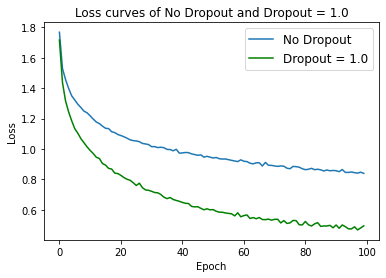

In [ ]:
# You code for Task 2 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.

# Run cifar10 without dropout
cifar10_model_without_drop = CNN(isCifar10=True).cuda()

print('Training cifar10 without dropout layers')
cifar10_history_without_drop = train(cifar10_model_without_drop, cifar10_trainloader)

# Run cifar10 with dropout = 1.0
cifar10_model_with_drop = CNN(isCifar10=True).cuda()

cifar10_model_with_drop.fc1 = MyLinear(16 * 5 * 5, 120,keep_prob=1.0)
cifar10_model_with_drop.fc2 = MyLinear(120, 84, keep_prob=1.0)
cifar10_model_with_drop.fc3 = MyLinear(84, 10, keep_prob=1.0)

print('Training cifar10 with dropout (prob = 1.0) layers ')
cifar10_history_with_drop = train(cifar10_model_with_drop, cifar10_trainloader)

#Plot
plot_loss(cifar10_history_without_drop['epochs_loss'],'No Dropout',cifar10_history_with_drop['epochs_loss'],'Dropout = 1.0')

# Task 3

Use your MyLinear module like before, but this time compare the loss curves of two runs: keep_prob = 1 and keep_prob = 0.5.

Training cifar10 with dropout (prob = 0.5) layers 


epoch: 1 loss: 2.0216152369976044
epoch: 2 loss: 1.8162446172597508
epoch: 3 loss: 1.7410995437142749
epoch: 4 loss: 1.7211875434344013
epoch: 5 loss: 1.7050542693274717
epoch: 6 loss: 1.7005350100807846
epoch: 7 loss: 1.6791743578699727
epoch: 8 loss: 1.6822914709337056
epoch: 9 loss: 1.669366905465722
epoch: 10 loss: 1.6710155851518114
epoch: 11 loss: 1.670742401232322
epoch: 12 loss: 1.6628326408875485
epoch: 13 loss: 1.6603081356734037
epoch: 14 loss: 1.6636033557976286
epoch: 15 loss: 1.6552425750220816
epoch: 16 loss: 1.6557676852680743
epoch: 17 loss: 1.6558820901749034
epoch: 18 loss: 1.6523170907360811
epoch: 19 loss: 1.6521566424829264
epoch: 20 loss: 1.6575315187995632
epoch: 21 loss: 1.6490693946058552
epoch: 22 loss: 1.6480701930510502
epoch: 23 loss: 1.6382973762229085
epoch: 24 loss: 1.6501809094722073
epoch: 25 loss: 1.6410495648160577
epoch: 26 loss: 1.6460464247502387
epoch: 27 loss: 1.6362525196745992
epoch: 28 loss: 1.6437162899722655
epoch: 29 loss: 1.6383015072594

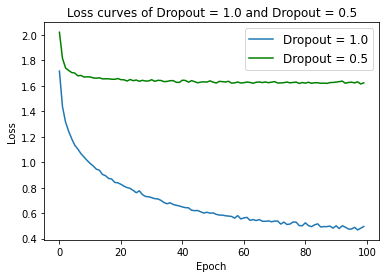

In [ ]:
# You code for Task 3 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.

# Run cifar10 with dropout = 0.5
cifar10_model_50percent_drop = CNN(isCifar10=True).cuda()

cifar10_model_50percent_drop.fc1 = MyLinear(16 * 5 * 5, 120,keep_prob=0.5)
cifar10_model_50percent_drop.fc2 = MyLinear(120, 84, keep_prob=0.5)
cifar10_model_50percent_drop.fc3 = MyLinear(84, 10, keep_prob=0.5)

print('Training cifar10 with dropout (prob = 0.5) layers ')
cifar10_history_50percent_drop = train(cifar10_model_50percent_drop, cifar10_trainloader)

# We'll use history from Task2 of 1.0 dropout probability
# Plot
plot_loss(cifar10_history_with_drop['epochs_loss'],'Dropout = 1.0', cifar10_history_50percent_drop['epochs_loss'],'Dropout = 0.5')

# Task 4

Implement a Module that performs Batch Normalization for the output of a Linear Module. In a nutshel, in it's forward procedure, this module should standartize the input (assumed to be of the same shape you use with nn.Linear, that is, (N, L) = N is the number of vectors in the batch, and L is the input vector), and then multiply it by gamma and add beta. Gamma and beta should be learnable, i.e., of nn.Parameter type.
Use running average to calculate the relevant information for testing time, and store them accordingly.

In [ ]:
# TODO: Implement the following Module. Size is the length of the input vectors.

class MyBatchNorm(nn.Module):
  def __init__(self, size, epsilon=1e-05):
    super(MyBatchNorm, self).__init__()
    self.eps = epsilon
    self.beta = nn.init.xavier_normal_(nn.Parameter(torch.empty(1, size)))
    self.gamma = nn.init.xavier_normal_(nn.Parameter(torch.empty(1, size)))
    
  def forward(self, x):
    std, mean = torch.var_mean(x,1)
    std = std.view(-1, 1)
    mean = mean.view(-1, 1)
    output = ((x - mean) / torch.sqrt(std + self.eps)).to(device=device)
    return (self.gamma * output).to(device=device) + self.beta.to(device=device)

# Task 5
You should add your new MyBatchNorm Module to our CNN, right after fc1. Then, train the network over CIFAR10 with and without your Module, and compare the loss curves (plot both of them onto the same figure, with two different colors).

Training cifar10 with batch norm layer


epoch: 1 loss: 1.6387006764610608
epoch: 2 loss: 1.383409299965327
epoch: 3 loss: 1.2790894024074078
epoch: 4 loss: 1.2181664900078129
epoch: 5 loss: 1.1757024171141286
epoch: 6 loss: 1.1369184269569814
epoch: 7 loss: 1.1053078369392704
epoch: 8 loss: 1.0769694864284247
epoch: 9 loss: 1.0500390104328592
epoch: 10 loss: 1.0224598220083863
epoch: 11 loss: 1.002140544122085
epoch: 12 loss: 0.9781251146147648
epoch: 13 loss: 0.9609779895593723
epoch: 14 loss: 0.9449414091650397
epoch: 15 loss: 0.9283695099099228
epoch: 16 loss: 0.9136931137181818
epoch: 17 loss: 0.8974596931754301
epoch: 18 loss: 0.8829007084326198
epoch: 19 loss: 0.8683810898025209
epoch: 20 loss: 0.8576944050534318
epoch: 21 loss: 0.8453363351679096
epoch: 22 loss: 0.8339852839708328
epoch: 23 loss: 0.8177463498432189
epoch: 24 loss: 0.809947228175588
epoch: 25 loss: 0.8042911927914247
epoch: 26 loss: 0.7890351242773855
epoch: 27 loss: 0.7812277020032828
epoch: 28 loss: 0.7726568917666251
epoch: 29 loss: 0.76277133612893

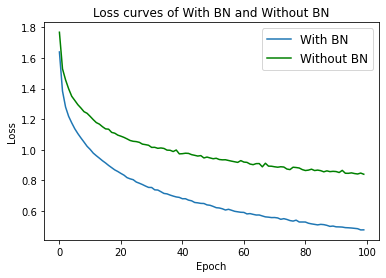

In [ ]:
# You code for Task 5 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.

# Run cifar10 with batch normalization
cifar10_model_with_bn = CNN(batch_norm_layer=True, isCifar10=True).cuda()

print('Training cifar10 with batch norm layer')
cifar10_history_with_bn = train(cifar10_model_with_bn, cifar10_trainloader)

# We'll use history from Task2 of no dropout

# Plot
plot_loss(cifar10_history_with_bn['epochs_loss'],'With BN', cifar10_history_without_drop['epochs_loss'],'Without BN')

# Task 6
Run your network over all training sets, with and without batch norm, as designed in Task 4 and 5.
Present 6 curves, two for each dataset.

Training Fashion-MNIST with batch norm layer


epoch: 1 loss: 0.529104109346268
epoch: 2 loss: 0.34640697232680395
epoch: 3 loss: 0.3087840706991431
epoch: 4 loss: 0.28882185504439156
epoch: 5 loss: 0.27327640461070196
epoch: 6 loss: 0.2592673660921199
epoch: 7 loss: 0.25007718176181826
epoch: 8 loss: 0.24113155685232154
epoch: 9 loss: 0.22843655026268347
epoch: 10 loss: 0.22249490124938479
epoch: 11 loss: 0.21224084599608822
epoch: 12 loss: 0.20711530896785138
epoch: 13 loss: 0.20043363803623443
epoch: 14 loss: 0.19389858395775914
epoch: 15 loss: 0.18652229843428358
epoch: 16 loss: 0.1795713512484716
epoch: 17 loss: 0.17703026925197005
epoch: 18 loss: 0.1702769655125199
epoch: 19 loss: 0.1648972502651824
epoch: 20 loss: 0.1588928266054219
epoch: 21 loss: 0.15768251104704437
epoch: 22 loss: 0.1531025927979499
epoch: 23 loss: 0.1495073687484754
epoch: 24 loss: 0.14463363371032756
epoch: 25 loss: 0.1409241042783833
epoch: 26 loss: 0.1358755862165708
epoch: 27 loss: 0.13401465307106264
epoch: 28 loss: 0.13052851462271065
epoch: 29 los

epoch: 1 loss: 0.5892120797320136
epoch: 2 loss: 0.3776773131186409
epoch: 3 loss: 0.3310415179335645
epoch: 4 loss: 0.3076445484101506
epoch: 5 loss: 0.28823325872820404
epoch: 6 loss: 0.2729616350760417
epoch: 7 loss: 0.2635455305031168
epoch: 8 loss: 0.2528064378670284
epoch: 9 loss: 0.24380931071105547
epoch: 10 loss: 0.2358145236378602
epoch: 11 loss: 0.22531716681883804
epoch: 12 loss: 0.22120346612064168
epoch: 13 loss: 0.21676130342530087
epoch: 14 loss: 0.20970649129594676
epoch: 15 loss: 0.2052868024204924
epoch: 16 loss: 0.19866333825796442
epoch: 17 loss: 0.19005766639020294
epoch: 18 loss: 0.18618881036361148
epoch: 19 loss: 0.18713563636577288
epoch: 20 loss: 0.18271814163433323
epoch: 21 loss: 0.18079036600205914
epoch: 22 loss: 0.1761673442295952
epoch: 23 loss: 0.1688509667510516
epoch: 24 loss: 0.16755574903592269
epoch: 25 loss: 0.16341882239170705
epoch: 26 loss: 0.16184886339552967
epoch: 27 loss: 0.15750827434073603
epoch: 28 loss: 0.15817177752614953
epoch: 29 lo

epoch: 1 loss: 0.331274989162921
epoch: 2 loss: 0.11518837650458279
epoch: 3 loss: 0.08031421519912588
epoch: 4 loss: 0.06388329689564541
epoch: 5 loss: 0.05485779687842296
epoch: 6 loss: 0.04426574666013039
epoch: 7 loss: 0.039442909735092666
epoch: 8 loss: 0.03567105782841346
epoch: 9 loss: 0.030236017426497192
epoch: 10 loss: 0.030336567465781172
epoch: 11 loss: 0.026938437339319016
epoch: 12 loss: 0.02045186739880478
epoch: 13 loss: 0.02056063587078987
epoch: 14 loss: 0.019206870936555123
epoch: 15 loss: 0.018249807431035135
epoch: 16 loss: 0.01932126237371636
epoch: 17 loss: 0.016047320242728955
epoch: 18 loss: 0.013924504820995562
epoch: 19 loss: 0.016507634763782062
epoch: 20 loss: 0.014063838114097393
epoch: 21 loss: 0.01382617681783265
epoch: 22 loss: 0.012730054888708375
epoch: 23 loss: 0.01237265922518154
epoch: 24 loss: 0.01273681262013466
epoch: 25 loss: 0.012123661077040358
epoch: 26 loss: 0.010143759991762964
epoch: 27 loss: 0.012245568344787136
epoch: 28 loss: 0.0119641

epoch: 1 loss: 0.41275395605147686
epoch: 2 loss: 0.13616178533785778
epoch: 3 loss: 0.0915519714607009
epoch: 4 loss: 0.0747729625734012
epoch: 5 loss: 0.06151168746113659
epoch: 6 loss: 0.0553634080683878
epoch: 7 loss: 0.0493465145555092
epoch: 8 loss: 0.047403917852534505
epoch: 9 loss: 0.04177858513800662
epoch: 10 loss: 0.036965464175052275
epoch: 11 loss: 0.03561405140754914
epoch: 12 loss: 0.03335316055611263
epoch: 13 loss: 0.03483262064179371
epoch: 14 loss: 0.03151124106593833
epoch: 15 loss: 0.029391770410742066
epoch: 16 loss: 0.02538381566420205
epoch: 17 loss: 0.026924712137474365
epoch: 18 loss: 0.029222700021864206
epoch: 19 loss: 0.024765494926976977
epoch: 20 loss: 0.023548198788237582
epoch: 21 loss: 0.02355868507957862
epoch: 22 loss: 0.024583856098153865
epoch: 23 loss: 0.025151719296902502
epoch: 24 loss: 0.02152765900892958
epoch: 25 loss: 0.02240882788444574
epoch: 26 loss: 0.017637079843297654
epoch: 27 loss: 0.026300663668786757
epoch: 28 loss: 0.021817676848

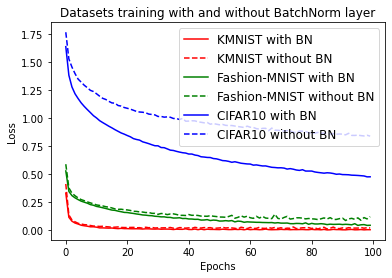

In [ ]:
# You code for Task 6 goes here. Note - you don't have to copy the entire network here, just modify everything in place, run it, and collect the losses. Then, here write your plots.

# Run Fashion-MNIST with batch normalization
fashion_mnist_model_with_bn = CNN(batch_norm_layer=True).cuda()

print('Training Fashion-MNIST with batch norm layer')
fashion_mnist_history_with_bn = train(fashion_mnist_model_with_bn, fashion_mnist_trainloader)

# Run Fashion-MNIST without batch normalization
fashion_mnist_model_without_bn = CNN().cuda()

print('Training Fashion-MNIST without batch norm layer')
fashion_mnist_history_without_bn = train(fashion_mnist_model_without_bn, fashion_mnist_trainloader)

# Run KMNIST with batch normalization
kmnist_model_with_bn = CNN(batch_norm_layer=True).cuda()

print('Training KMNIST with batch norm layer')
kmnist_history_with_bn = train(kmnist_model_with_bn, kmnist_trainloader)

# Run KMNIST without batch normalization
kmnist_model_without_bn = CNN().cuda()

print('Training KMNIST without batch norm layer')
kmnist_history_without_bn = train(kmnist_model_without_bn, kmnist_trainloader)


# print all curves on one canvas
plt.title("Datasets training with and without BatchNorm layer")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot(kmnist_history_with_bn['epochs_loss'], color='red')
plt.plot(kmnist_history_without_bn['epochs_loss'], color='red', linestyle="--")

plt.plot(fashion_mnist_history_with_bn['epochs_loss'], color='green')
plt.plot(fashion_mnist_history_without_bn['epochs_loss'], color='green', linestyle="--")

plt.plot(cifar10_history_with_bn['epochs_loss'], color='blue')
plt.plot(cifar10_history_without_drop['epochs_loss'], color='blue', linestyle="--") # Using first model from task1

plt.legend(('KMNIST with BN','KMNIST without BN','Fashion-MNIST with BN','Fashion-MNIST without BN',
            'CIFAR10 with BN','CIFAR10 without BN'), fontsize=12)